In [27]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt

In [28]:
from pygam import s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit, cross_validate, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, SplineTransformer
from sklearn.model_selection import GridSearchCV

In [29]:
boston_df = load_data("Boston")
boston_df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


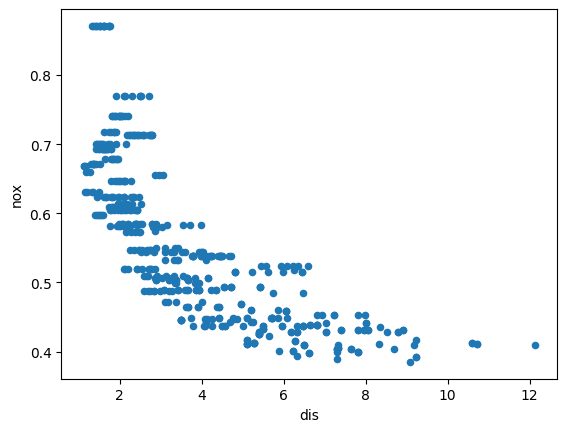

In [30]:
boston_df.plot.scatter(x='dis', y='nox')
plt.show()

In [31]:
X = boston_df[["dis"]]
y = boston_df.nox

### a)

In [32]:
cols_transform = ColumnTransformer([
    ('poly', PolynomialFeatures(degree=3), ['dis']),
])

poly_pipe = Pipeline([
    ('cols_transform', cols_transform),
    ('ols', LinearRegression())
])

a_result = cross_val_score(poly_pipe, X, y, scoring='neg_mean_squared_error', cv=5)

poly_pipe.fit(X, y)

Pipeline(steps=[('cols_transform',
                 ColumnTransformer(transformers=[('poly',
                                                  PolynomialFeatures(degree=3),
                                                  ['dis'])])),
                ('ols', LinearRegression())])

In [33]:
a_result.mean()

-0.004647367459422983

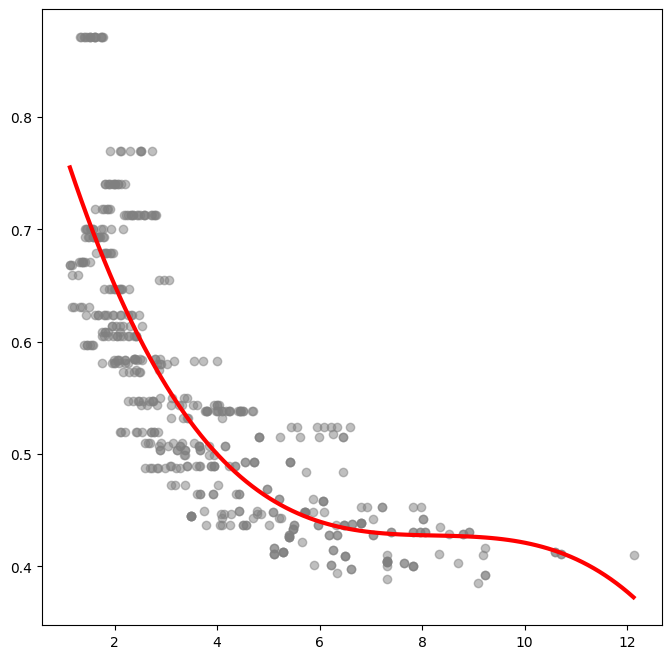

In [34]:
fig, ax = subplots(figsize=(8, 8))
ax.scatter(x='dis', y='nox', data=boston_df, facecolor="gray", alpha=0.5)

dis_grid = np.linspace(X.dis.min(), X.dis.max(), 100)
dis_df = pd.DataFrame({'dis': dis_grid})
preds = poly_pipe.predict(dis_df)

ax.plot(dis_grid, preds, color='red', linewidth=3)
plt.show()

### b)

For degree 1, the mean is -0.006032109223148159
For degree 2, the mean is -0.004570384881436277
For degree 3, the mean is -0.004647367459422983
For degree 4, the mean is -0.004756118478674706
For degree 5, the mean is -0.004969650255228574
For degree 6, the mean is -0.02208332390018134
For degree 7, the mean is -0.08601104447362791
For degree 8, the mean is -2.4179944930280555
For degree 9, the mean is -0.13094958662512546
For degree 10, the mean is -84.65187016629548


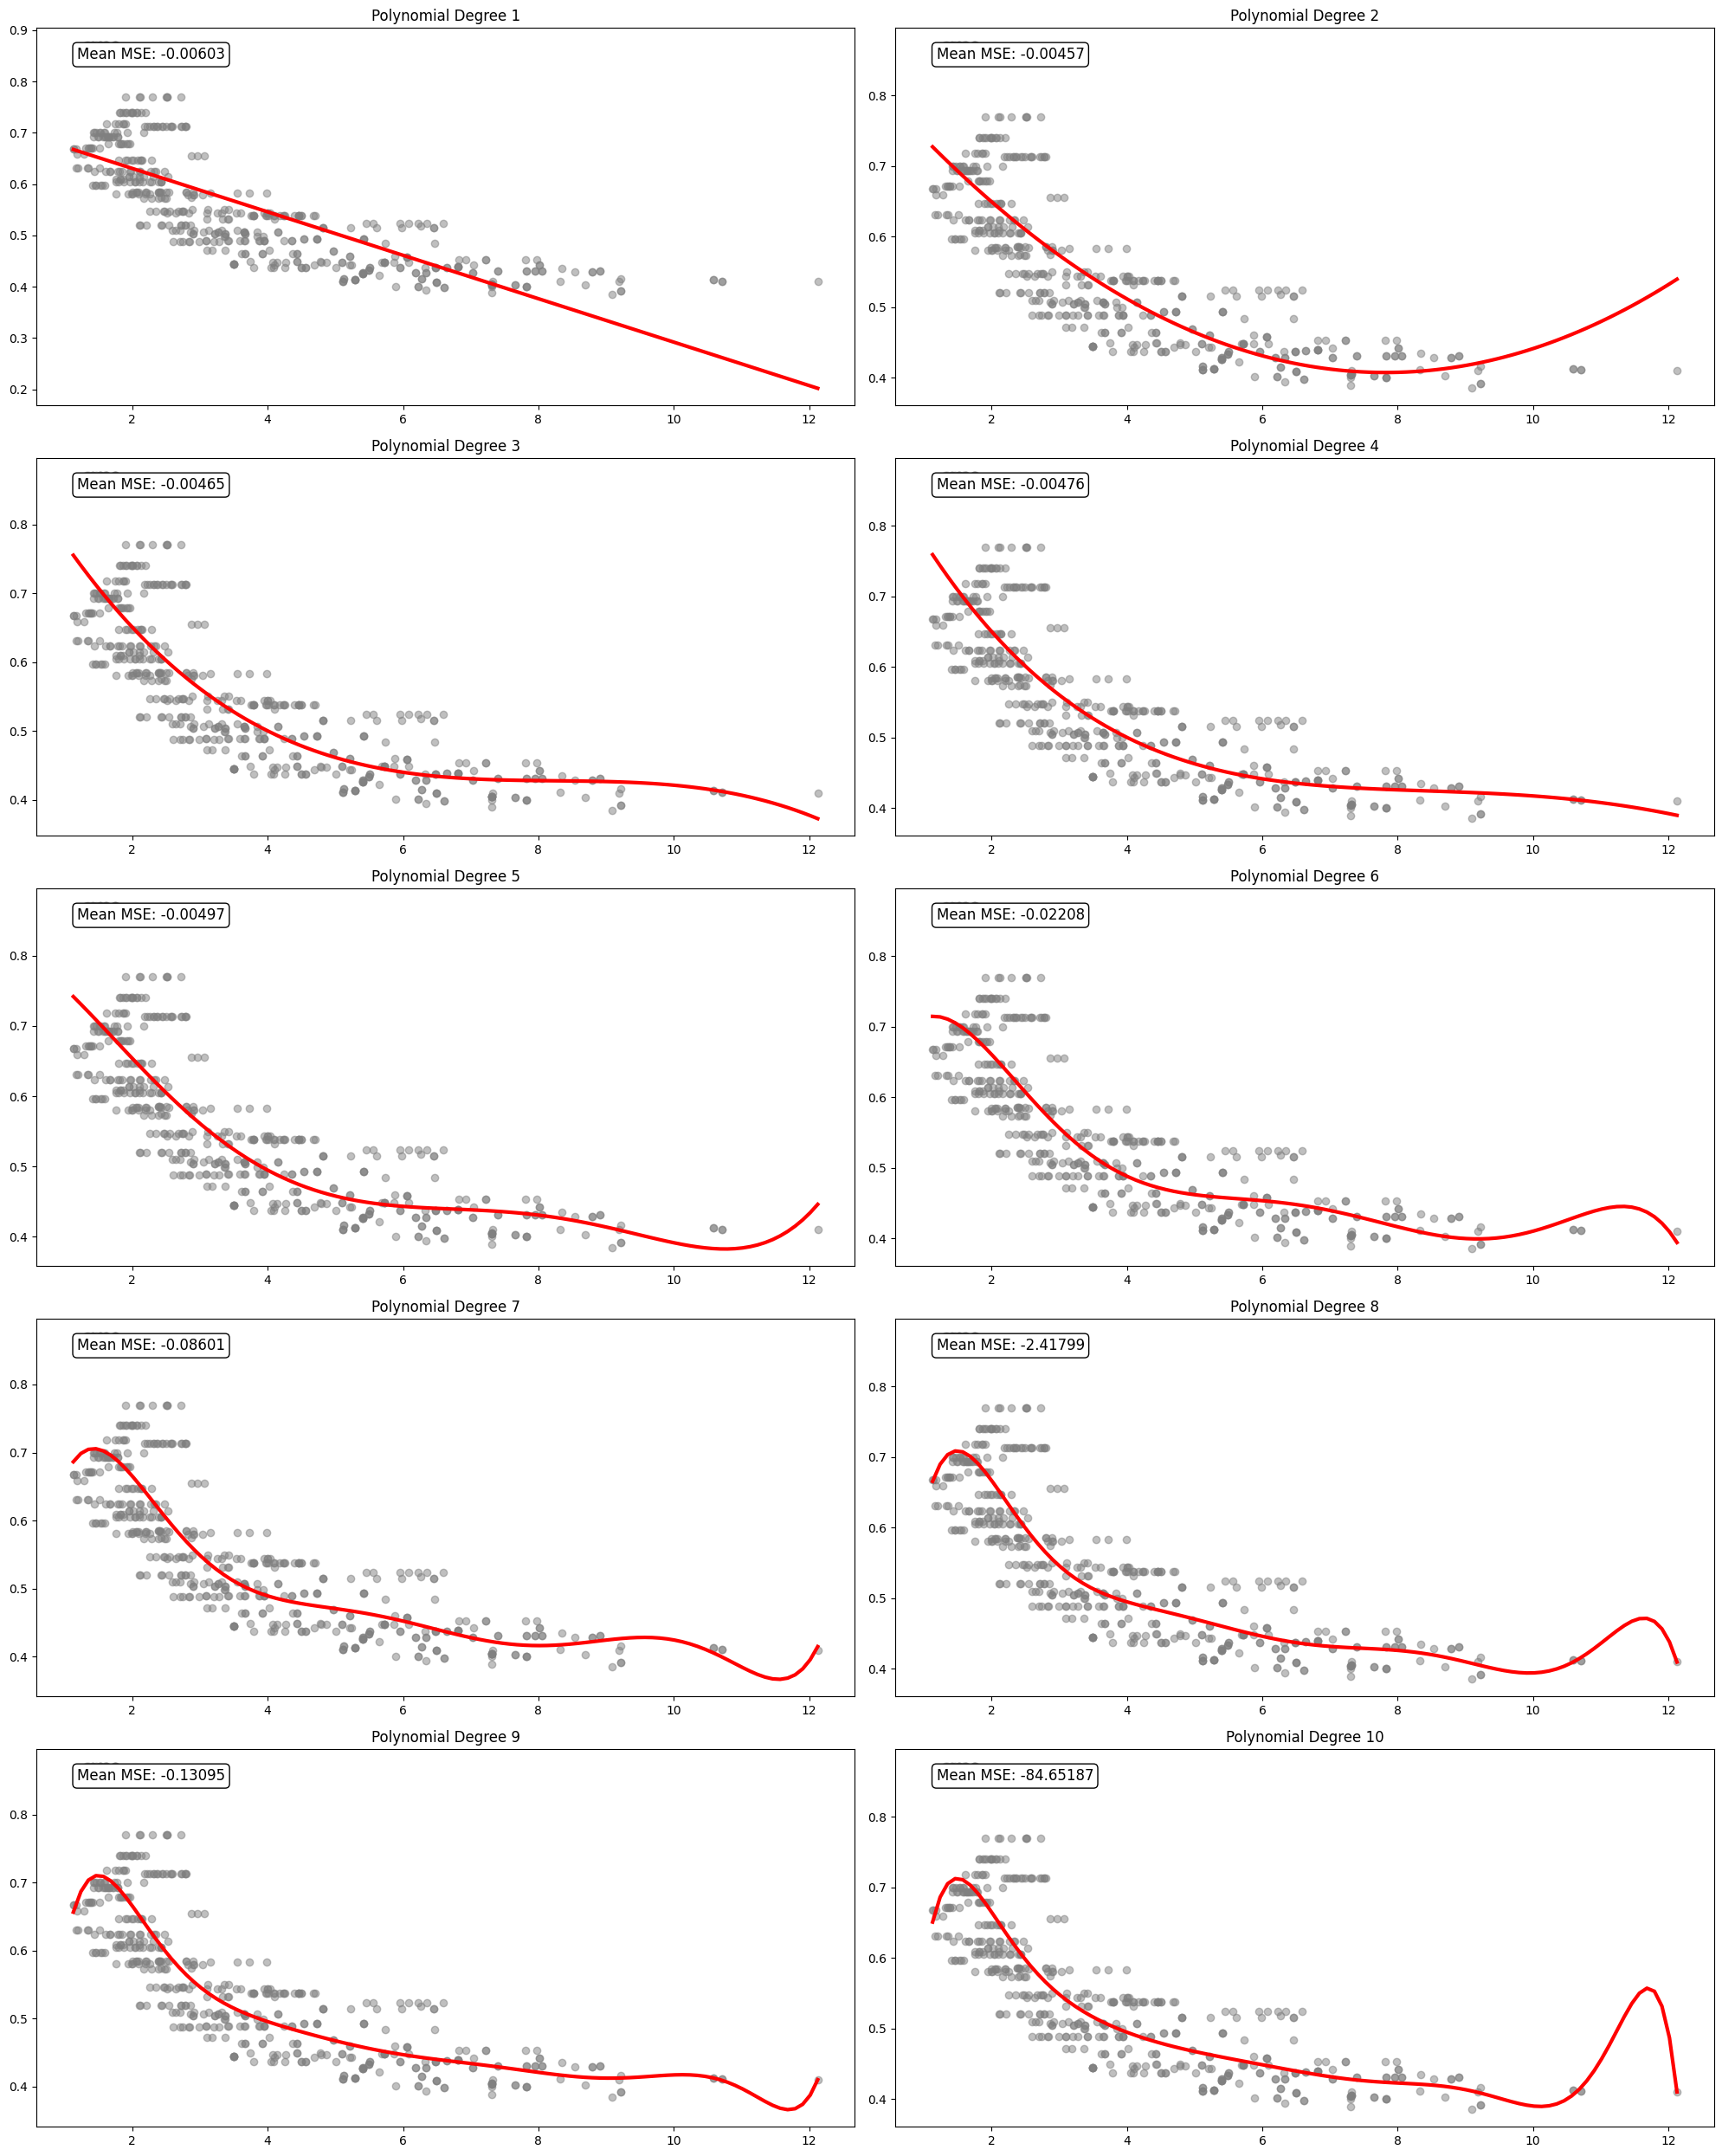

In [35]:
degrees = range(1, 11)

fig, axs = plt.subplots(5, 2, figsize=(20, 25))
axs = axs.ravel()

for i, knot in enumerate(degrees):
    ax = axs[i]
    ax.scatter(x='dis', y='nox', data=boston_df, facecolor="gray", alpha=0.5)
    
    cols_transform = ColumnTransformer([
        ('poly', PolynomialFeatures(degree=knot), ['dis']),
    ])
    
    poly_pipe = Pipeline([
        ('cols_transform', cols_transform),
        ('ols', LinearRegression())
    ])
    
    b_result = cross_val_score(poly_pipe, X, y, scoring='neg_mean_squared_error', cv=5)
    mean_score = b_result.mean()

    print(f'For degree {knot}, the mean is {mean_score}')
    
    poly_pipe.fit(X, y)
    preds = poly_pipe.predict(dis_df)
    
    ax.plot(dis_grid, preds, color='red', linewidth=3)
    ax.set_title(f'Polynomial Degree {knot}')
    ax.text(0.05, 0.95, f'Mean MSE: {mean_score:.5f}', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.show()

### d)

In [36]:
cols_transform = ColumnTransformer([
    ('poly', PolynomialFeatures(), ['dis']),
])

poly_pipe = Pipeline([
    ('cols_transform', cols_transform),
    ('ols', LinearRegression())
])

grid_search_poly = GridSearchCV(
    poly_pipe,
    param_grid={'cols_transform__poly__degree': degrees},
    scoring='neg_mean_squared_error',
    cv=5
)

grid_result = grid_search_poly.fit(X, y)


In [37]:
grid_result.best_params_

{'cols_transform__poly__degree': 2}

In [38]:
grid_result.best_score_

-0.004570384881436277

### e)

In [46]:
cols_spline = ColumnTransformer(
    transformers=[
        (
            "spline_dis",
            SplineTransformer(
                n_knots=3, degree=1, include_bias=False, knots="quantile"
            ),
            ["dis"],
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [47]:
spline_pipe = Pipeline(
    steps=[
        ("cols_spline", cols_spline),
        ("ols", LinearRegression()),
    ]
)

fitted_spline = spline_pipe.fit(X, y)


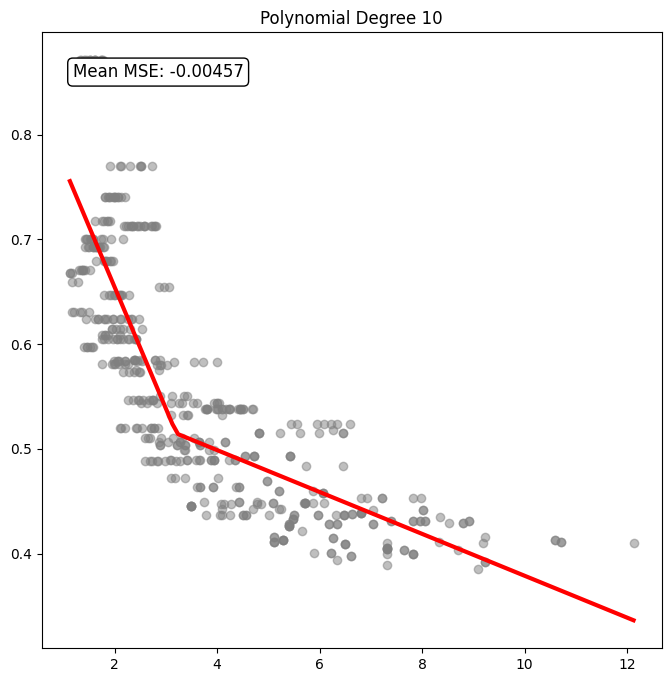

In [48]:

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(x='dis', y='nox', data=boston_df, facecolor="gray", alpha=0.5)

b_result = cross_val_score(poly_pipe, X, y, scoring='neg_mean_squared_error', cv=5)
mean_score = b_result.mean()

preds = fitted_spline.predict(dis_df)

ax.plot(dis_grid, preds, color='red', linewidth=3)
ax.set_title(f'Polynomial Degree {knot}')
ax.text(0.05, 0.95, f'Mean MSE: {mean_score:.5f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

plt.show()

For 2 knots, the mean is -0.004363478557378823
For 3 knots, the mean is -0.005054882628785246
For 4 knots, the mean is -0.004750656309968488
For 5 knots, the mean is -0.005097427288626559
For 6 knots, the mean is -0.005224664784304397
For 7 knots, the mean is -0.005190438628633075
For 8 knots, the mean is -0.005221078372684449
For 9 knots, the mean is -0.005197816297962755
For 10 knots, the mean is -0.005229814932031977


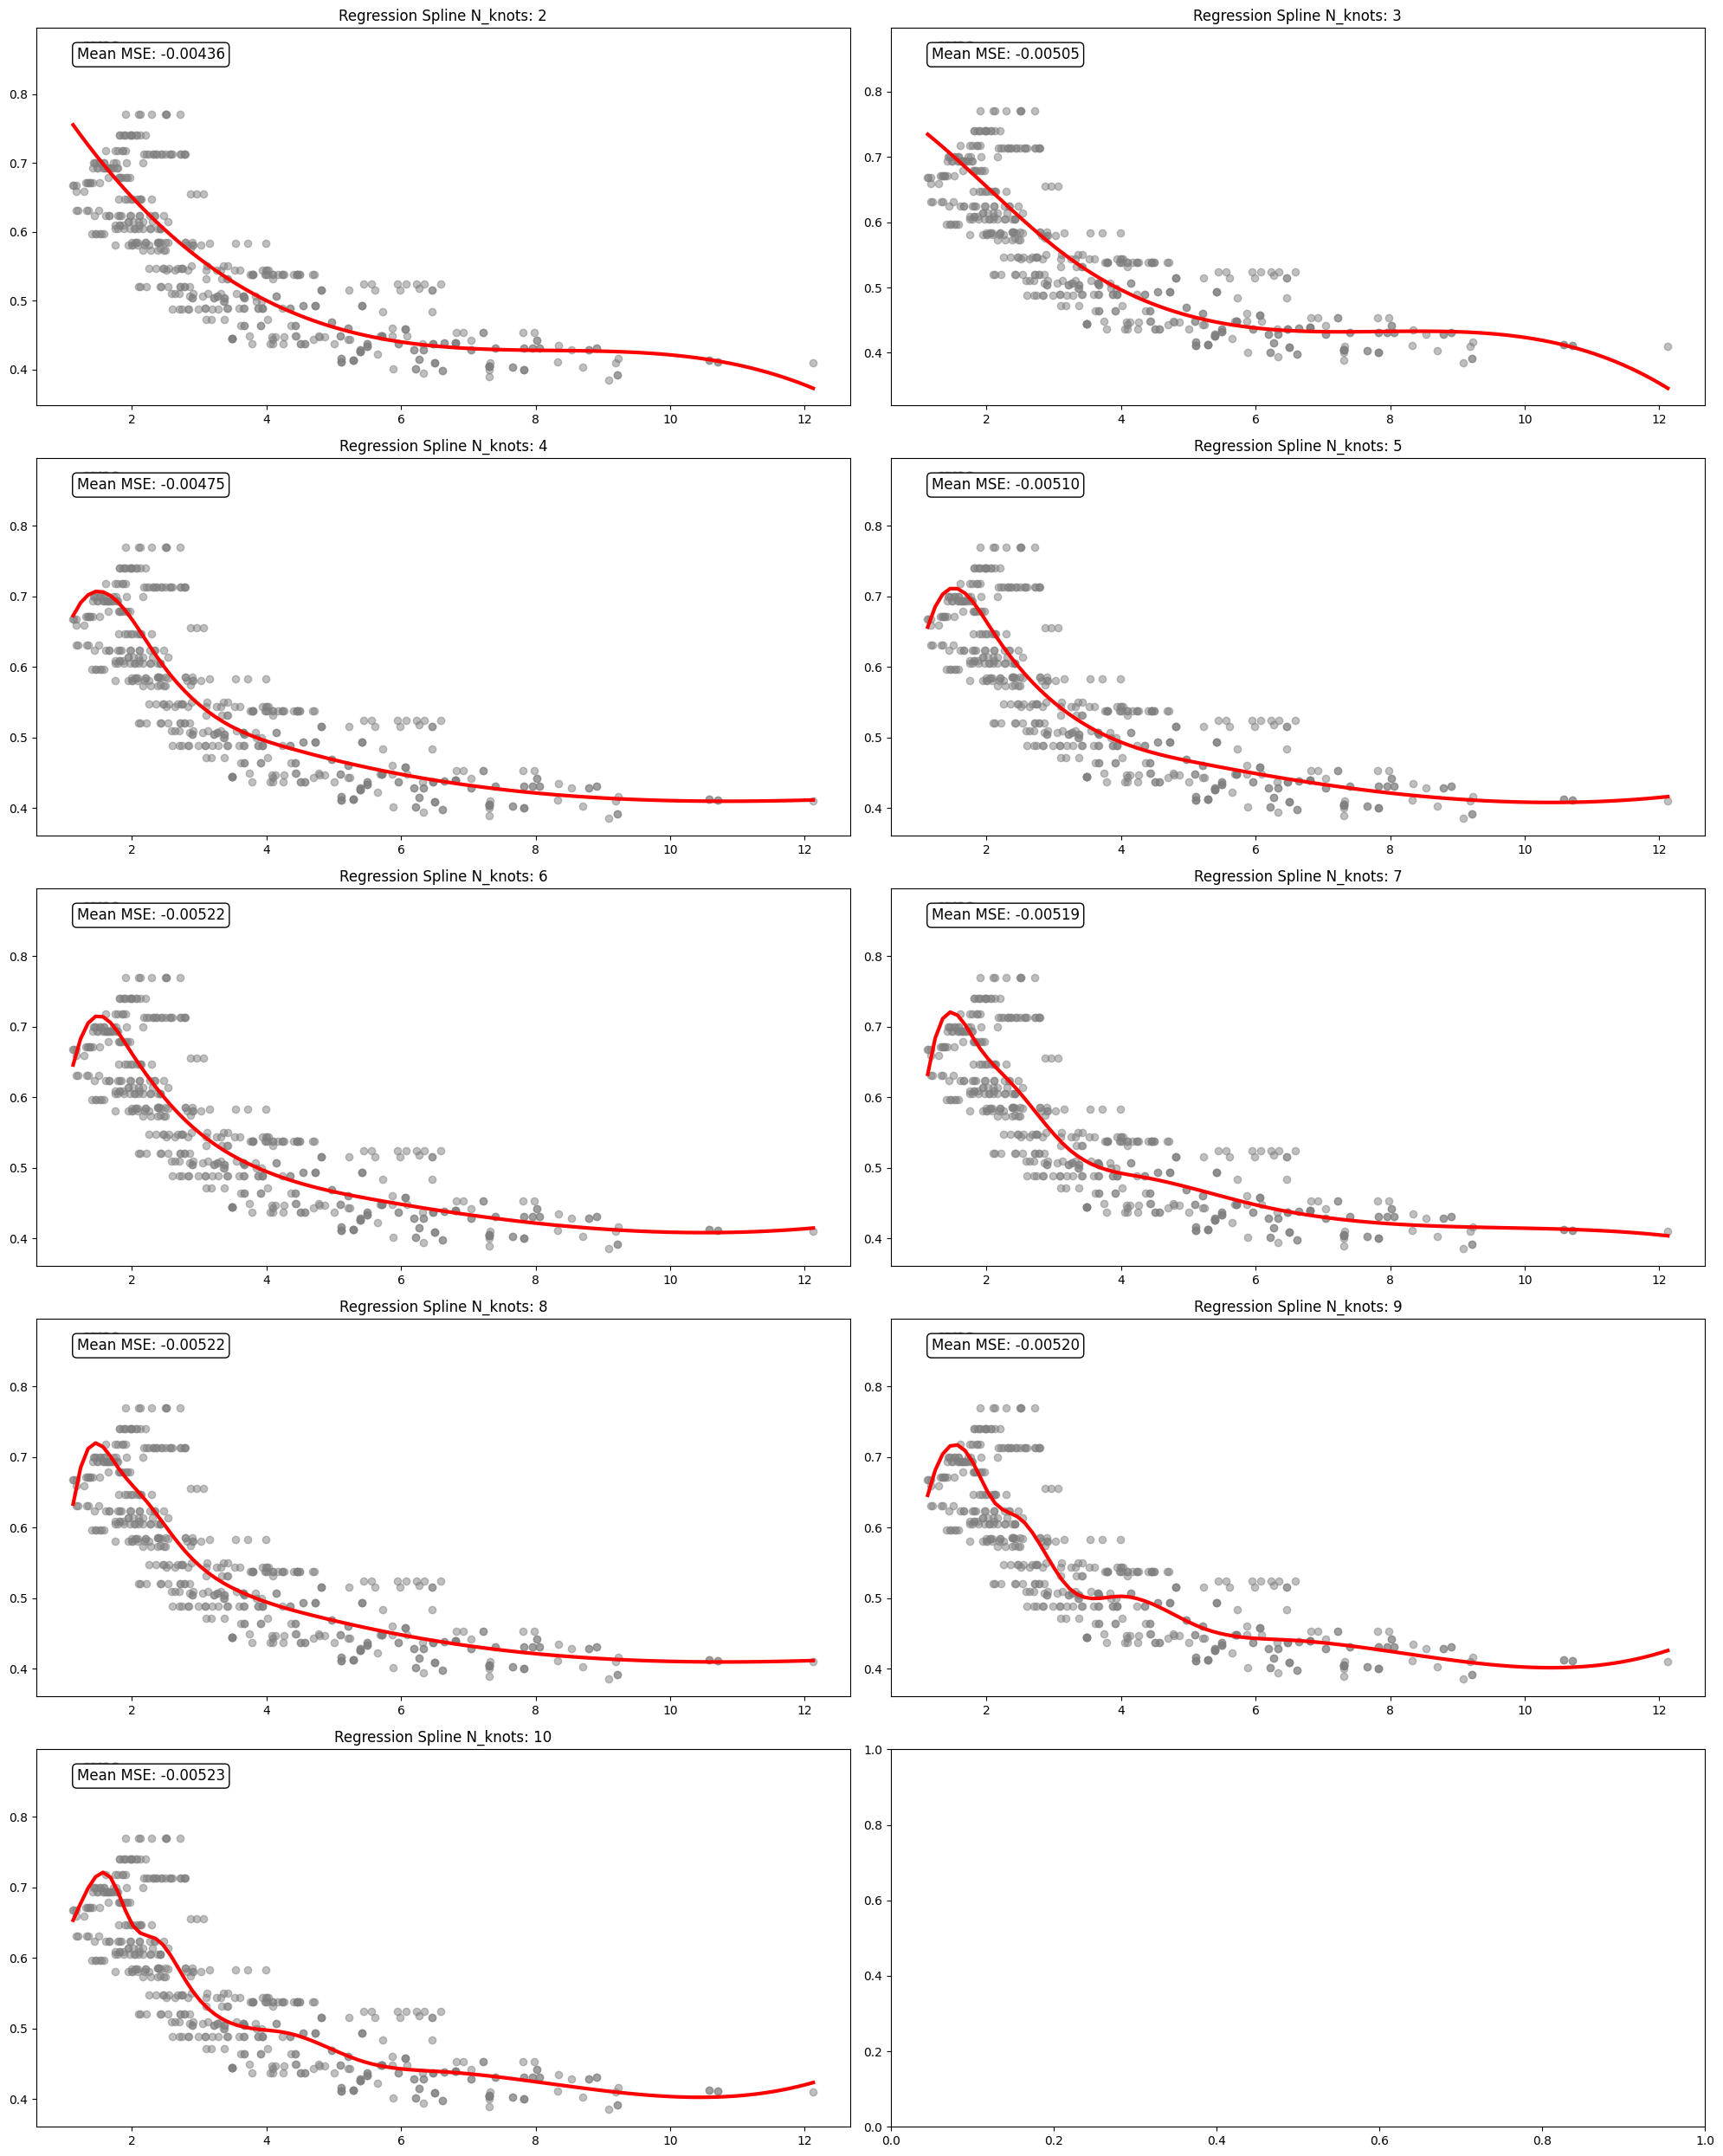

In [51]:
n_knots = range(2, 11)

fig, axs = plt.subplots(5, 2, figsize=(20, 25))
axs = axs.ravel()

for i, knot in enumerate(n_knots):
    ax = axs[i]
    ax.scatter(x='dis', y='nox', data=boston_df, facecolor="gray", alpha=0.5)
    
    cols_spline = ColumnTransformer(
        transformers=[
            (
                "spline_dis",
                SplineTransformer(
                    n_knots=knot, degree=3, include_bias=False, knots="quantile"
                ),
                ["dis"],
            ),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )
    
    spline_pipe = Pipeline(
        steps=[
            ("cols_spline", cols_spline),
            ("ols", LinearRegression()),
        ]
    )

    
    b_result = cross_val_score(spline_pipe, X, y, scoring='neg_mean_squared_error', cv=5)
    mean_score = b_result.mean()

    print(f'For {knot} knots, the mean is {mean_score}')
    
    fitted_spline = spline_pipe.fit(X, y)
    preds = spline_pipe.predict(dis_df)
    
    ax.plot(dis_grid, preds, color='red', linewidth=3)
    ax.set_title(f'Regression Spline N_knots: {knot}')
    ax.text(0.05, 0.95, f'Mean MSE: {mean_score:.5f}', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.show()

### e)

In [52]:
spline_grid_search = GridSearchCV(
    spline_pipe,
    param_grid={'cols_spline__spline_dis__n_knots': n_knots},
    scoring='neg_mean_squared_error',
    cv=5
)

spline_results = spline_grid_search.fit(X, y)

In [53]:
spline_results.best_params_

{'cols_spline__spline_dis__n_knots': 2}

In [54]:
spline_results.best_score_

-0.004363478557378823